# Galaxy Selector MOC

**Compared to the "Simple Galaxy Selector, this works with Multi-Ordering-Sky-Maps**


***NOTE (this note may be wrong, just copied from old notebook)***: Before anything can happen, download the GW event localization map. Open the terminal and type:
"curl -O https://gracedb.ligo.org/api/superevents/sid/files/bayestar.fits,0"
with sid = superevent ID (could be incorporated into this notebook)

Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 90% credible regions for the event, add them as a column to the data
- only keep data within the 90% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [63]:
import numpy as np
from scipy.stats import norm
import scipy as sc

from astropy.io import fits
from astropy.table import Table, hstack
from astropy import table

import healpy as hp
import astropy_healpix as ah

from astropy.table import QTable

import psycopg2

from scipy.stats import norm


from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

import gasel as gs

Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [64]:
path = "/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/S230522abayestar.multiorder.fits,1"
skymap = QTable.read(path)

skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1045,0.029303756273802613,1593.8240337328732,515.8564456938193,3.563354517213414e-07
1046,0.028392681869408246,1577.2742104062504,510.38311474193097,3.638682797470182e-07
1047,0.02349500703651242,1480.7296444977283,479.20190913876587,4.128543780193468e-07
1049,0.028459908912918216,1578.6321710060924,510.7294673088845,3.6325507210447283e-07
1050,0.029225602009572485,1592.7193718515464,515.2442411347533,3.568633032212571e-07


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [65]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  30827


In [66]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  293.90625 30.69158768492234 with prob [1/deg^2] of:  8.263083256297391e-05 and UNIQ ID:  30827


Now open the fits file and read basics info from the header

In [67]:
fits_gw = fits.open(path)
header = fits_gw[1].header
dist_mean = header["DISTMEAN"]
dist_std = header["DISTSTD"]
print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)

The dist_mean and dist_std values:  3101.911440270933 Mpc 1032.142383672648 Mpc


In [68]:
# these values (924, 188Mpc) are close to z= 0.19, 0.03

### Get DESI data

Establish a connection to the DESI database and load the daily data.

In [69]:
try:
    db = psycopg2.connect(host='decatdb.lbl.gov', database='desidb', user='desi', password = "5kFibers!", port="5432")
    cursor = db.cursor()
except (Exception, psycopg2.Error) as error:
    print(error)

cursor = db.cursor()

In [70]:
redux = 'daily'
query = 'SELECT f.targetid,f.target_ra,f.target_dec,c.tileid,c.night,r.z,r.zerr,r.zwarn,r.deltachi2,f.flux_z,f.bgs_target,f.ebv, f.sersic, f.mws_target, c.filename\n' \
                    f'FROM {redux}.tiles_fibermap f\n' \
                    f'INNER JOIN {redux}.cumulative_tiles c ON f.cumultile_id=c.id\n' \
                    f'INNER JOIN {redux}.tiles_redshifts r ON r.cumultile_id=c.id AND r.targetid=f.targetid\n' \
                    f'WHERE q3c_radial_query( f.target_ra, f.target_dec, {ra.deg}, {dec.deg}, 50);'

cursor.execute(query)
rows = cursor.fetchall()

## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of z-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 90% credible region (i.e. with a certainty of 90% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

### Create DESI data Table and data clean up

In [72]:
if rows:
    data = Table(list(map(list, zip(*rows))),
                             names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'TILEID', 'NIGHT', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'FLUX_Z', 'BGS_TARGET', 'EBV', 'SERSIC', 'MWS_TARGET','FILENAME'])
data[:5:-1] 

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71
39633054372724796,247.142648499851,38.811505440908,25435,20230520,0.36128150437353,8.75863235901406e-05,0,146.109357248992,36.8784484863281,514,0.00851269625127316,4.0,0,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
39633044901986975,247.356025802072,38.3648092744739,25435,20230520,5.25898696080585e-05,6.12892339678604e-06,0,2053.86738169171,71.0185623168945,0,0.00904854945838451,0.0,17,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
-254359010,246.599542771627,39.4412005253432,25435,20230520,1.34451722450903,0.000119095005760056,2053,3.62523132562637,0.0,0,0.00975194107741117,0.0,0,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
39633059078734602,246.798732733926,39.0657353306997,25435,20230520,-3.84890194848649e-05,4.23183454976143e-06,0,5662.7716538402,113.394309997559,0,0.0107947746291757,0.0,768,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
39633054376922004,247.663371281755,38.8095387301562,25435,20230520,3.09542247868878e-05,4.75760113093703e-06,0,6910.24263383773,116.152069091797,0,0.00726486509665847,0.0,17,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
39633049641551936,247.043202760099,38.5006942255478,25435,20230520,0.174914166990973,4.82542323477764e-05,0,988.144366179593,173.299377441406,514,0.00890133250504732,4.366295337677,0,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
39633049641552273,247.059924850491,38.3902040521157,25435,20230520,0.455458014949545,1.47603191454041e-05,0,751.373251080513,23.459379196167,257,0.0102210314944386,0.580598890781403,0,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
39633044897793062,247.066480862594,38.3465183797582,25435,20230520,0.239952732860842,6.61649887912269e-05,0,159.081957055256,62.5650253295898,514,0.00949942599982023,2.16679096221924,0,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits
39633049641553034,247.102932601802,38.389857668431,25435,20230520,0.175996562485287,7.83110737803604e-06,0,1334.46322470903,40.7736434936523,514,0.00981849897652864,1.0,0,daily/tiles/cumulative/25435/20230520/redrock-9-25435-thru20230520.fits


In [73]:
data = data[data['ZWARN']==0]
data = data[data['Z']>=0]
data = data[data['FLUX_Z']>0]
data = table.unique(data, keys = "TARGETID")

In [74]:
print(f"We have {len(data)} objects in the full catalog") 

We have 4694341 objects in the full catalog


### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [75]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probdensity = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

uniq = skymap["UNIQ"][sorter_i]
#to make things easier in future, I will now also append the UNIQ pixels DISTMU, DISTSIGMA and DISTNORM values. However, be careful, since these DO NOT CORRESPOND THE TARGETS IN DESI DIRECTLY!

distmu = skymap[sorter_i]["DISTMU"]
distsigma = skymap[sorter_i]["DISTSIGMA"]
distnorm = skymap[sorter_i]["DISTNORM"]


In [76]:
# len(UNIQ), len(data), len(skymap)

In [77]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [78]:
data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity}), Table({"DISTMU": distmu}), Table({"DISTSIGMA": distsigma}), Table({"DISTNORM": distnorm})])

In [79]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64,float64,float64,float64
39627460672749994,316.075157442061,-13.6310868745627,21872,20211029,0.416700916600313,2.46290891466202e-05,0,175.43090057373,15.7218132019043,65545,0.0463812276721001,1.0,0,daily/tiles/cumulative/21872/20211029/redrock-9-21872-thru20211029.fits,16326,2.774175531193883e-05,2326.3580258968173,752.5801204793004,1.6727339549619812e-07
39627460672750523,316.129752386656,-13.6292699138002,21872,20211029,0.317717201006356,5.86501301186487e-05,0,754.035196565092,146.238967895508,131074,0.0483423806726933,6.0,0,daily/tiles/cumulative/21872/20211029/redrock-9-21872-thru20211029.fits,16326,2.774175531193883e-05,2326.3580258968173,752.5801204793004,1.6727339549619812e-07
39627460672750566,316.132722579841,-13.6443986382141,21872,20211029,0.262338143982214,2.49150650660767e-05,0,677.188760980964,26.616096496582,65537,0.0473134927451611,0.656544327735901,0,daily/tiles/cumulative/21872/20211029/redrock-9-21872-thru20211029.fits,16326,2.774175531193883e-05,2326.3580258968173,752.5801204793004,1.6727339549619812e-07
39627460672751152,316.186054070507,-13.6391033327971,21872,20211029,0.205103903960105,9.65350436552956e-06,0,941.831816613674,12.1276807785034,65545,0.0495129190385342,0.5,0,daily/tiles/cumulative/21872/20211029/redrock-9-21872-thru20211029.fits,16326,2.774175531193883e-05,2326.3580258968173,752.5801204793004,1.6727339549619812e-07
39627466519613448,314.271103128212,-13.4087247838399,21872,20211029,0.501685292682823,8.14879662100166e-05,0,267.10806242004,40.0189247131348,131074,0.0459239855408669,1.74498915672302,0,daily/tiles/cumulative/21872/20211029/redrock-1-21872-thru20211029.fits,16332,2.9947924204889715e-05,2386.436077796873,772.0360825251853,1.58956455826681e-07


In [80]:
print(f"The highest and lowest probability values in our catalog are: {np.min(probdensity)} and {np.max(probdensity)}")

The highest and lowest probability values in our catalog are: 2.0258913187191926e-05 and 7.740471663183922e-05


### Sort the skymap table and get 90% credible region

In [81]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [82]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [83]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [84]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
30827,0.2712610218444879,3347.4248298385446,1082.6894852163814,8.079305698237059e-08
56168,0.2712558843532586,3347.4035959907383,1082.6829149469697,8.079407778520979e-08
56170,0.2712471550927869,3347.3773618922824,1082.6666546877664,8.079545398327668e-08
30826,0.2712452369877947,3347.3680299460825,1082.6651356239838,8.079588330351662e-08
56127,0.2712174881419412,3347.2526504708267,1082.6288027979672,8.080143953777071e-08


In [85]:
# now get 90% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.9
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.9)

# print area
area_90 = pixel_area[:i].sum()
area_90.to_value(u.deg**2)

24218.657426213435

### can be deleted, just tried things out

In [86]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [87]:
np.max(prob)

<Quantity 0.00012013>

In [88]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
30827,0.2712610218444879,3347.4248298385446,1082.6894852163814,8.079305698237059e-08,6.935153266861194e-05
56168,0.2712558843532586,3347.4035959907383,1082.6829149469697,8.079407778520979e-08,6.935021919980466e-05
56170,0.2712471550927869,3347.3773618922824,1082.6666546877664,8.079545398327668e-08,6.934798744682866e-05
30826,0.2712452369877947,3347.3680299460825,1082.6651356239838,8.079588330351662e-08,6.934749705746078e-05
56127,0.2712174881419412,3347.2526504708267,1082.6288027979672,8.080143953777071e-08,6.934040269138991e-05


In [89]:
skymap_prob = Table(skymap_sort, copy = True)

In [90]:
skymap_prob.sort("PROB", reverse = True)

In [91]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
11555,0.11746599874987697,2532.502520442503,819.130563602206,1.4115426746394087e-07,0.00012012705687474
3320,0.02936262391289069,1594.9283732640865,516.1833836425061,3.5584614641812193e-07,0.00012011120257142887
6402,0.11742850594081668,2532.039244311846,819.1386831328434,1.412007707227517e-07,0.0001200887147088851
7440,0.11738032243125528,2531.1595244575537,819.2858677954423,1.4128483175800458e-07,0.0001200394396569117
8012,0.11732371849190307,2531.057719209934,819.0057862090923,1.4130427289796124e-07,0.00011998155341992175


### Compare Tables, only leave 90% credible region in DESI data table

Now we can get a Table that only contains the 90% credible region. From there we only leave the matching objects in the DESI data

In [92]:
# we simply select only the entries that are within the 90% credible region
skymap_90 = skymap_sort[:i]

In [93]:
print("This is the number of UNIQ ID of objects which should lie within the 90% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_90["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 90% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 2876


In [94]:
mask = np.in1d(data["UNIQ"], skymap_90["UNIQ"])
data_90 = data[mask]

In [95]:
print(f"We now have {len(data_90)} objects in the 90% credible region")
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_90["TARGET_RA"]), np.max(data_90["TARGET_RA"]), np.min(data_90["TARGET_DEC"]), np.max(data_90["TARGET_DEC"]))

max_probdens_in_desi = np.max(data_90["PROBDENSITY"])
max_probdens_in_ligo = np.max(skymap["PROBDENSITY"]).to_value(u.deg**-2)
print(f"We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...")
print(f"This is {np.allclose(max_probdens_in_desi, max_probdens_in_ligo)}")

We now have 4694341 objects in the 90% credible region
Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  230.929933245455 353.450287347815 -13.6443986382141 80.169733932861
We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...
This is False


In [96]:
data_90.sort('PROBDENSITY', reverse=True)

In [97]:
data_90[:2]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64,float64,float64,float64
39632957249428111,279.528998640127,33.8029856616974,81112,20210513,2.34626748854458,0.000752057176905733,0,96.0491077620536,3.55239152908325,0,0.0679977536201477,0.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08
39632952212063115,279.294167607132,33.4805978544231,81112,20210513,0.414173631003969,8.85297457464023e-05,0,10.5778310447931,26.3261489868164,257,0.0675732344388962,2.12837624549866,0,daily/tiles/cumulative/81112/20210513/zbest-9-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08


In [98]:
print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
min_z = np.min(data_90["Z"])
max_z = np.max(data_90["Z"])
print(f"However, we have not used the distance data at all. Therefore our redhsifts range from {min_z} to {max_z}")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redhsifts range from 4.81932436205922e-10 to 6.85686043636468


### Calculate all the distances of the objects from the redshifts

In [99]:
distances = Distance(z=data_90["Z"], cosmology=Planck18)
distances_err = Distance(z=data_90["ZERR"], cosmology=Planck18)

data_90 = hstack([data_90, Table({"DIST_Z": distances}), Table({"DIST_Z_ERR": distances_err})])

In [100]:
data_90[:5]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64,float64,float64,float64,float64,float64
39632957249428111,279.528998640127,33.8029856616974,81112,20210513,2.34626748854458,0.000752057176905733,0,96.0491077620536,3.55239152908325,0,0.0679977536201477,0.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,19339.31800400032,3.3341859421024473
39632952212063115,279.294167607132,33.4805978544231,81112,20210513,0.414173631003969,8.85297457464023e-05,0,10.5778310447931,26.3261489868164,257,0.0675732344388962,2.12837624549866,0,daily/tiles/cumulative/81112/20210513/zbest-9-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2334.0631954755336,0.392290146101148
39632962274200717,279.742352512558,34.0406583580893,81112,20210513,0.715396865995214,9.31982872898698e-05,0,29.6244165673561,7.85115766525269,0,0.076921358704567,1.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,4502.561769779485,0.4129787142337032
39632962274200481,279.733411019701,33.9664986261796,81112,20210513,0.499811639580795,9.69123761215224e-05,0,10.792769536376,31.1279239654541,0,0.07459507137537,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2918.3090875802363,0.42943774598854334
39632957249427367,279.503563693254,33.7733527604534,81112,20210513,0.262598383450057,5.54371147170733e-05,0,11.3345417492092,0.486104398965836,0,0.0671378001570702,0.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,1375.887022396523,0.24564491852548473


### Lets check how much the distance measurement changes in the 90% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

Our distance ranges from 1761.2485562775692 Mpc to 3347.4248298385446 Mpc
Let's visualize the distance distribution of the LIGO event in the 90% credible region


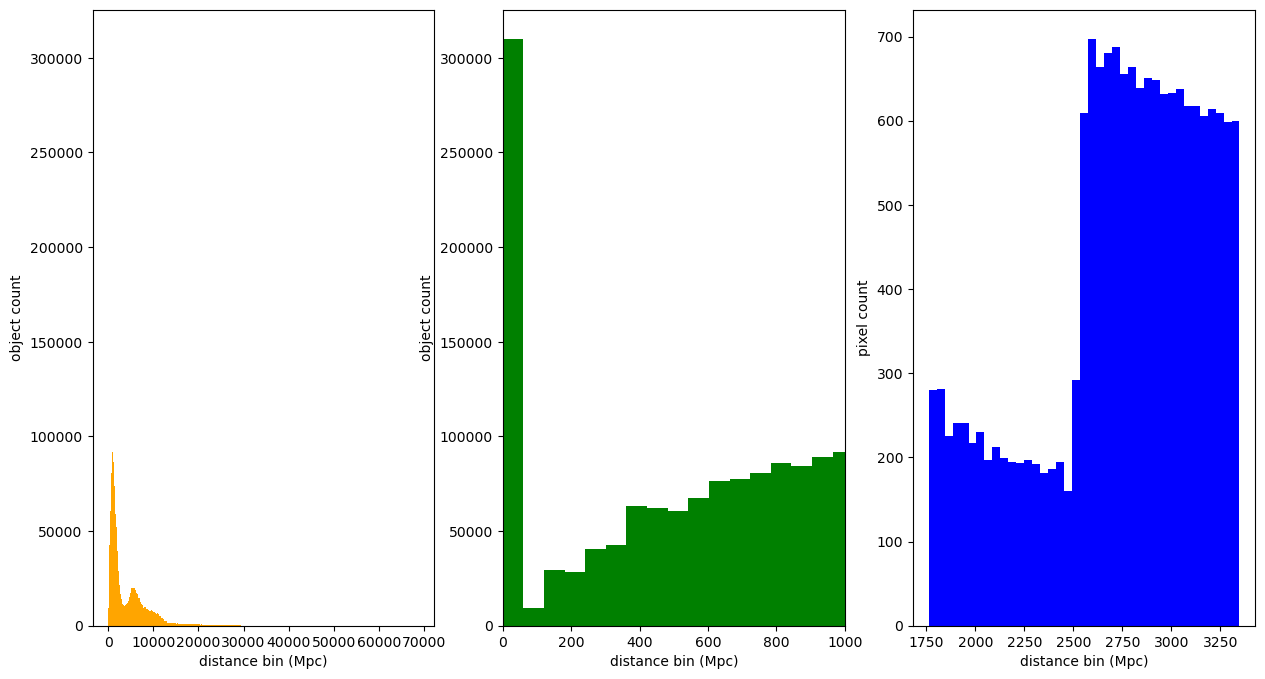

In [101]:
dist_max_90 = np.max(skymap_90["DISTMU"])*u.Mpc
dist_min_90 = np.min(skymap_90["DISTMU"])*u.Mpc
print(f"Our distance ranges from {dist_min_90} to {dist_max_90}")
print("Let's visualize the distance distribution of the LIGO event in the 90% credible region")

fig, ax = plt.subplots(ncols = 3, figsize = (15,8))


ax[0].hist(data_90["DIST_Z"], bins = "auto", color = "orange")
ax[1].hist(data_90["DIST_Z"], bins = "auto", color = "green")
ax[2].hist(skymap_90["DISTMU"], bins = "auto", color = "blue")


for axis in ax:
    axis.set_xlabel("distance bin (Mpc)")

ax[0].set_ylabel("object count")
ax[1].set_ylabel("object count")
ax[2].set_ylabel("pixel count")

ax[1].set_xlim(0,1000)
    
plt.show()

In [102]:
len(skymap_90), len(data_90)

(16874, 4694341)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.

In [103]:
z_selection_mask = data_90["DIST_Z"] - data_90["DIST_Z_ERR"] <  data_90["DISTMU"] + data_90["DISTSIGMA"]
z_selection_mask &= data_90["DIST_Z"] + data_90["DIST_Z_ERR"] >  data_90["DISTMU"] - data_90["DISTSIGMA"]

data_90_z = data_90[z_selection_mask]

In [104]:
remaining_obj = np.size(np.where(z_selection_mask == True))
deleted_obj = np.size(np.where(z_selection_mask == False))

print(f"The z-range selection has deleted {deleted_obj} objects from originally {deleted_obj+remaining_obj} in the data set")
print(f"Therefore, we have {remaining_obj} objects left in the search region")

The z-range selection has deleted 4033758 objects from originally 4694341 in the data set
Therefore, we have 660583 objects left in the search region


In [105]:
highest_prob_dens = np.max(data_90_z["PROBDENSITY"])
print(f"Our highest remaing probability density is {highest_prob_dens} compared to the originally highest prob density of {max_probdens_in_ligo}")
print(f"The difference in prob density is {max_probdens_in_ligo-highest_prob_dens}")

Our highest remaing probability density is 7.740471663183922e-05 compared to the originally highest prob density of 8.263083256297391e-05
The difference in prob density is 5.2261159311346944e-06


In [106]:
data_90_z[:5]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64,float64,float64,float64,float64,float64
39632952212063115,279.294167607132,33.4805978544231,81112,20210513,0.414173631003969,8.85297457464023e-05,0,10.5778310447931,26.3261489868164,257,0.0675732344388962,2.12837624549866,0,daily/tiles/cumulative/81112/20210513/zbest-9-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2334.0631954755336,0.392290146101148
39632962274200481,279.733411019701,33.9664986261796,81112,20210513,0.499811639580795,9.69123761215224e-05,0,10.792769536376,31.1279239654541,0,0.07459507137537,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2918.3090875802363,0.42943774598854334
39632962274198952,279.679909399735,34.0605667937843,81112,20210513,0.620662101106397,9.22578876546957e-05,0,16.0793663971126,22.074275970459,0,0.0742209479212761,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3788.057675745966,0.4088113361918642
39632962274198115,279.649628940594,33.9382222148794,81112,20210513,0.619760980109084,5.15479085613828e-05,0,17.8373381197453,35.7083778381348,0,0.0696481466293335,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3781.392539937417,0.2284109501898885
39632962270010861,279.602397819564,33.8936841864184,81112,20210513,0.527670269872489,7.86754188726973e-05,0,50.20505048614,12.8523759841919,0,0.0678077712655067,1.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3114.326877296438,0.34862133823820096


### get the apparent, absolute magnitudes and luminosities

in order to do this: flux > 0 selection

In [107]:
# get the apparent mags
data_90_z = data_90_z[data_90_z["FLUX_Z"] > 0]
app_mag_z = gs.app_mag(data_90_z["FLUX_Z"])
flux_selection_cut = len(data_90_z)
print(f"We have {flux_selection_cut} objects remaining in our catalog, i.e. {remaining_obj-flux_selection_cut} had to be cut out due to bad fluxes")

# get the absolute mags
abs_mag_z = gs.abs_mag(app_mag_z, data_90_z["Z"], 0,0,0)

# get the luminosities
lums_z = gs.lum(abs_mag_z, band = "z")

We have 660583 objects remaining in our catalog, i.e. 0 had to be cut out due to bad fluxes


In [108]:
data_f = hstack([data_90_z, Table({"APP_MAG_Z": app_mag_z}), Table({"ABS_MAG_Z": abs_mag_z}), Table({"LUM_Z": lums_z})])

In [109]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,APP_MAG_Z,ABS_MAG_Z,LUM_Z
,,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,W
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39632952212063115,279.294167607132,33.4805978544231,81112,20210513,0.414173631003969,8.85297457464023e-05,0,10.5778310447931,26.3261489868164,257,0.0675732344388962,2.12837624549866,0,daily/tiles/cumulative/81112/20210513/zbest-9-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2334.0631954755336,0.392290146101148,18.949031663105977,-22.89153138951695,1.6674551900835333e+37
39632962274200481,279.733411019701,33.9664986261796,81112,20210513,0.499811639580795,9.69123761215224e-05,0,10.792769536376,31.1279239654541,0,0.07459507137537,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2918.3090875802363,0.42943774598854334,18.76712460757838,-23.558531830074514,3.08215409649962e+37
39632962274198952,279.679909399735,34.0605667937843,81112,20210513,0.620662101106397,9.22578876546957e-05,0,16.0793663971126,22.074275970459,0,0.0742209479212761,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3788.057675745966,0.4088113361918642,19.14028383060941,-23.751799083437913,3.6826568181125015e+37
39632962274198115,279.649628940594,33.9382222148794,81112,20210513,0.619760980109084,5.15479085613828e-05,0,17.8373381197453,35.7083778381348,0,0.0696481466293335,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3781.392539937417,0.2284109501898885,18.61807469627305,-24.27018411910341,5.93629211473424e+37
39632962270010861,279.602397819564,33.8936841864184,81112,20210513,0.527670269872489,7.86754188726973e-05,0,50.20505048614,12.8523759841919,0,0.0678077712655067,1.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3114.326877296438,0.34862133823820096,19.727541445143466,-22.739279524012844,1.4492837597141853e+37


In [110]:
max_lum_z = np.max(data_f["LUM_Z"])*u.W
prob_dens_max_lum = data_f[data_f["LUM_Z"] == max_lum_z]["PROBDENSITY"]
print(f"The maximum luminosity in our cataloge in the z-band is {max_lum_z} with a prob density of {prob_dens_max_lum}")

The maximum luminosity in our cataloge in the z-band is 1.2266470710102596e+39 W with a prob density of      PROBDENSITY     
---------------------
3.666576683123629e-05


In [111]:
arg_errfc = abs(data_f["DIST_Z"]-data_f["DISTMU"])/(data_f["DIST_Z_ERR"]**2+data_f["DISTSIGMA"]**2)
P_gal_unnorm = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc))
#dist_mean*u.Mpc, dist_std*u.Mpc
arg_errfc_c = abs(data_f["DIST_Z"].value-dist_mean)/(data_f["DIST_Z_ERR"].value**2+dist_std**2)
P_gal_unnorm_const = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc_c))

# now lets quickly normalize

P_gal_sum = np.sum(P_gal_unnorm)
P_gal_const_sum = np.sum(P_gal_unnorm_const)

P_gal = 1/P_gal_sum * P_gal_unnorm
P_gal_const = 1/P_gal_const_sum * P_gal_unnorm_const

In [112]:
data_f = hstack([data_f, Table({"P_GAL": P_gal.value}), Table({"P_GAL_C": P_gal_const.value})])

In [113]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FLUX_Z,BGS_TARGET,EBV,SERSIC,MWS_TARGET,FILENAME,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,APP_MAG_Z,ABS_MAG_Z,LUM_Z,P_GAL,P_GAL_C
,,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,W,,
int64,float64,float64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,str71,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39632952212063115,279.294167607132,33.4805978544231,81112,20210513,0.414173631003969,8.85297457464023e-05,0,10.5778310447931,26.3261489868164,257,0.0675732344388962,2.12837624549866,0,daily/tiles/cumulative/81112/20210513/zbest-9-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2334.0631954755336,0.392290146101148,18.949031663105977,-22.89153138951695,1.6674551900835333e+37,2.3994564455339936e-06,2.399845905459516e-06
39632962274200481,279.733411019701,33.9664986261796,81112,20210513,0.499811639580795,9.69123761215224e-05,0,10.792769536376,31.1279239654541,0,0.07459507137537,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,2918.3090875802363,0.42943774598854334,18.76712460757838,-23.558531830074514,3.08215409649962e+37,4.437804022888033e-06,4.4386655514346664e-06
39632962274198952,279.679909399735,34.0605667937843,81112,20210513,0.620662101106397,9.22578876546957e-05,0,16.0793663971126,22.074275970459,0,0.0742209479212761,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3788.057675745966,0.4088113361918642,19.14028383060941,-23.751799083437913,3.6826568181125015e+37,5.301591468842174e-06,5.300636784840568e-06
39632962274198115,279.649628940594,33.9382222148794,81112,20210513,0.619760980109084,5.15479085613828e-05,0,17.8373381197453,35.7083778381348,0,0.0696481466293335,4.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3781.392539937417,0.2284109501898885,18.61807469627305,-24.27018411910341,5.93629211473424e+37,8.54600578488074e-06,8.544469985324941e-06
39632962270010861,279.602397819564,33.8936841864184,81112,20210513,0.527670269872489,7.86754188726973e-05,0,50.20505048614,12.8523759841919,0,0.0678077712655067,1.0,0,daily/tiles/cumulative/81112/20210513/zbest-8-81112-thru20210513.fits,31243,7.740471663183922e-05,3274.4162641041653,1059.8083381397971,8.442499801894188e-08,3114.326877296438,0.34862133823820096,19.727541445143466,-22.739279524012844,1.4492837597141853e+37,2.087145576231956e-06,2.0875181241557186e-06


## Analyse the data: How much luminosity do we cover? Which galaxies should we observe?

Lets look into what information we can retrieve from here. First we define, how many galaxies we could observe (N_galaxies).

We then calculate the luminosity (lum) from all the galaxies in this area, i.e. the total luminosity. From there do some comparison between the covered luminosity and total luminosity depending on the ranking by probability:
- simple "Maximum lum that could be covered" by looking at the brightest galaxies
- Calculate the probability this way (from https://arxiv.org/pdf/1710.05452.pdf w/o normalization), both using a static and variable distance and error: $$P_{gal} = k^{-1}\tilde{L_z}\cdot P_{2D}\left(1-\text{erf}\left(\frac{|D_{Gal}-D_{LVC}|}{\sigma_{D,gal}^{2}+\sigma_{D,LVC}^{2}}\right)\right)$$
- others may follow...

Since we have the actual luminosity (here in z-band though), we don't need to again calculate the $$\tilde{L}_{gal}$$ values. In the mentioned paper, they only use a fixed distance and error for the LIGO data. I will try both, to get an idea what the differences are.

In [114]:
N_galaxies = 20 # how many galaxies we can cover

In [115]:
total_lum = np.sum(data_f["LUM_Z"])

### Compare lum with luminosity ranking

https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10

In [116]:
data_sort_by_lums = data_f.group_by("LUM_Z")
data_sort_by_lums = data_sort_by_lums[::-1]

In [117]:
lum_after_N_highest = np.sum(data_sort_by_lums["LUM_Z"][:N_galaxies])

In [118]:
print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")
print("The TARGETID values of these galaxies are: \n", data_sort_by_lums["TARGETID"][:N_galaxies])

The theoretical maximum luminosity we could cover is 1.338516472326886e+40, i.e. 0.1058808329338184 % of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID    
-----------------
39633502190175579
39628374557066779
39633451388766544
39627808460247354
39633225353530994
39628428705531143
39628245632552051
39633091844639742
39628212543688143
39628518170039615
39633414021712524
39627946951967689
39633490148331342
39633419876963292
39633063948321850
39628504026843512
39628380114520686
39633283343979115
39633162568991140
39633494384576298


### Compare lum with P_Gal ranking

In [119]:
data_sort_by_PGal = data_f.group_by("P_GAL")
data_sort_by_PGal = data_sort_by_PGal[::-1]

lum_after_N_PGal = np.sum(data_sort_by_PGal["LUM_Z"][:N_galaxies])

In [120]:
print(f"The maximum luminosity we cover when ranked by P_gal is {lum_after_N_PGal}, i.e. {lum_after_N_PGal*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal is 1.2082044789929408e+40, i.e. 0.0955727473175999% of the total luminosity
The TARGETID values of these galaxies are: 
    TARGET_RA        TARGET_DEC    ...      TARGETID             P_GAL         
---------------- ---------------- ... ----------------- ----------------------
254.378966243912 25.0603503476827 ... 39628374557066779 0.00010212422479998402
272.348893009799 48.5470195367965 ... 39633225353530994  9.075539566576028e-05
268.719195114419 71.5401722504212 ... 39633502190175579   8.36275587715123e-05
267.069207993741 40.7315325824462 ... 39633091844639742  7.946479564186824e-05
272.781268001595 65.6886086369931 ... 39633451388766544  7.486421155448195e-05
280.697521880561 52.1813246932094 ... 39633283343979115  5.882132801234944e-05
248.139889477539 27.4585209668413 ... 39628428705531143  5.514245457922669e-05
255.882613896611 31.6765092468937 ... 39628518170039615  5.513922657199153e-05
281.138972303754 49.7781473954365 ..

In [121]:
data_sort_by_PGal_C = data_f.group_by("P_GAL_C")
data_sort_by_PGal_C = data_sort_by_PGal_C[::-1]

lum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_Z"][:N_galaxies])

In [122]:
print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal_C is 1.2082044789929408e+40, i.e. 0.0955727473175999% of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID             P_GAL         
----------------- ----------------------
39628374557066779 0.00010212422479998402
39633225353530994  9.075539566576028e-05
39633502190175579   8.36275587715123e-05
39633091844639742  7.946479564186824e-05
39633451388766544  7.486421155448195e-05
39633283343979115  5.882132801234944e-05
39628428705531143  5.514245457922669e-05
39628518170039615  5.513922657199153e-05
39633245255502120  5.486766745642644e-05
39628212543688143  5.442217851346897e-05
39633063948321850  5.307014944196385e-05
39628380114520686  5.148924530991533e-05
39633419876963292  5.139191146972362e-05
39633030901402666  5.063611838396693e-05
39628245632552051 4.7212513221648896e-05
39633021338391375  4.507434202099171e-05
39633260728287845 4.4012779793793595e-05
39628200887714086  4.376988591214431e-05
3963

In [123]:
data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "Z", "P_GAL"][:N_galaxies].write('PGAl_S200129.ecsv', delimiter=',', format='ascii', overwrite = True)
